In [1]:
# Import required packages

import sys
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Import models and functions

sys.path.append(r'C:\Users\prm0026\Documents\GitHub\PredictiveCombGrowthModels3D\Functions')
from Functions_CombGrowthModels import arrange_nest
from Functions_CombGrowthModels import model_dilation
from Functions_CombGrowthModels import model_neighbor
from Functions_CombGrowthModels import model_random_placement

In [3]:
# Import data

# dataframe with info on comb position and orientation
data_path = 'C:/Users/prm0026/Documents/GitHub/PredictiveCombGrowthModels3D/Data/CombDataframe.csv'
data = pd.read_csv(data_path, sep=',')

# numpy array with all comb images for all colonies at all timepoints
mask_path = 'C:/Users/prm0026/Documents/GitHub/PredictiveCombGrowthModels3D/Data/CombMaskArray.npy'
masks = np.load(mask_path)

# colony names list
colonyNamesAll = [
    'DD1',
    'DD2',
    'DD4',
    'DD5',
    'DD6',
    'DD7',
    'SH2',
    'SH3',
    'SH4',
    'SH5',
    'SH6',
    'SH7'
        ]

In [5]:
# Run all models

# see Functions_CombGrowthModels.py for detailed annotations of each model

masks = masks
colonynames = colonyNamesAll
data = data

treatment = 'DD' # define treatment as control (DD) for dataframe, (will change later)

df_model_compare = pd.DataFrame(columns=['colony', 'treatment', 'week', 'accuracyrand', 'accuracydilate', 'accuracyneib',]) # create dataframe to save model results to

for c in range(len(masks)): # for all colonies
    for w in range(len(masks[c])-1): # and all weeks
    
        # Dilation model
        masksweek, masksweekobs, masksweekpreddilate, accuracydilate, areamatchdilate = model_dilation(masks, c, w, data, colonynames, xbeespace=0, ybeespace=10)
        
        # Neighbor model
        masksweek, masksweekobs, masksweekpredneib, accuracyneib, areamatchneib = model_neighbor(masks, c, w, data, colonynames, second_round=True, downsample=True)
        
        #Random placement model
        masksweek, masksweekobs, masksweekpredrand, accuracyrand, areamatchrand = model_random_placement(masks, c, w, data, colonynames, allsides=False, downsample=True)
        
        if c>5: # when colony value is greater 5, change treatment to shuffle
            treatment = 'SH'

        df_new = pd.DataFrame({'colony':[colonynames[c]], # create new dataframe with values from current nest
                              'treatment':[treatment],
                              'week':[w+1],
                              'accuracyrand':[accuracyrand],
                              'accuracydilate': [accuracydilate],
                              'accuracyneib':[accuracyneib],
                              })
        df_model_compare = pd.concat([df_model_compare,df_new]).reset_index(drop=True)

df_model_compare.head()

C:\Users\prm0026\Box\3D_nest_2021\initial_nest\Functions_CombGrowthModels.py:317: RuntimeWarning: overflow encountered in ulong_scalars
  areamatch = ((np.sum(masksweekpred)-np.sum(masksweekobs))/np.sum(masksweekobs))*100 # a check to see how close the total predicted area is to the observed area (should be about 100%)
C:\Users\prm0026\Box\3D_nest_2021\initial_nest\Functions_CombGrowthModels.py:317: RuntimeWarning: overflow encountered in ulong_scalars
  areamatch = ((np.sum(masksweekpred)-np.sum(masksweekobs))/np.sum(masksweekobs))*100 # a check to see how close the total predicted area is to the observed area (should be about 100%)
C:\Users\prm0026\Box\3D_nest_2021\initial_nest\Functions_CombGrowthModels.py:239: RuntimeWarning: overflow encountered in ulong_scalars
  areamatch = ((np.sum(masksweekpred)-np.sum(masksweekobs))/np.sum(masksweekobs))*100 # a check to see how close the total predicted area is to the observed area (should be about 100%)


,colony,treatment,week,accuracyrand,accuracydilate,accuracyneib
0,DD1,DD,1,22.895183,75.46119,54.876616
1,DD1,DD,2,21.558005,69.872206,67.171292
2,DD1,DD,3,29.504016,83.426107,56.64242
3,DD1,DD,4,32.80083,72.675246,57.091646
4,DD1,DD,5,33.70333,79.215102,75.996249


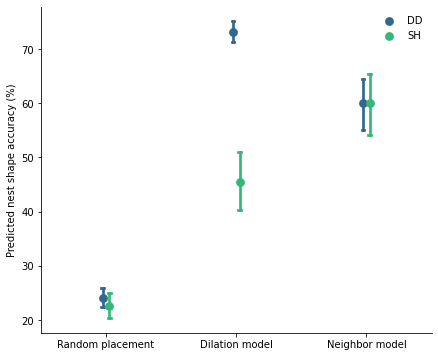

In [19]:
# convert dataframe from wide to long and plot the results

df_model_compare_longall = pd.melt(df_model_compare, id_vars=['colony', 'treatment', 'week'], value_vars=['accuracyrand', 'accuracydilate', 'accuracyneib'])
df_model_compare_longall = df_model_compare_longall.rename(columns={"variable": "model", "value": "accuracy"})
df_model_compare_longall['model'] = df_model_compare_longall['model'].str.replace('accuracyrand','random_placement')
df_model_compare_longall['model'] = df_model_compare_longall['model'].str.replace('accuracydilate','equal_dilation')
df_model_compare_longall['model'] = df_model_compare_longall['model'].str.replace('accuracyneib','neib_adder')

plt.figure(figsize=(7,6))
ax = sns.pointplot(data=df_model_compare_longall,
              x='model',
              y='accuracy',
              hue='treatment',
              dodge=True,
              capsize=.02,
              palette='viridis',
              join=False,
                    )
plt.legend(frameon=False)
labels = ['Random placement', 'Dilation model', 'Neighbor model']
x = np.arange(len(labels)) 
plt.xticks(x, labels)
plt.ylabel('Predicted nest shape accuracy (%)')
plt.xlabel('')
sns.despine()
